# Ultimate Fandoms

## 1 Motivation

Almost all people are interested in pop culture to some extent - some more than others of course. With the spread of the Internet in the 00’s, fans of the same books, movies, games, or music, etc. were given the opportunity to share and cultivate experiences about their common interests with each other. 
Furthermore, this also gives the opportunity to investigate and clarify the interaction across the different communities. This can be done by downloading data from these platforms, and then creating and analyzing social graphs from the data. And this is exactly what we intend to do.

We will use fandom.com, which is wiki hosting service where roughly all fandoms have a wiki. From the Fandom API we can collect data concerning the top contributing users for every fandom-wiki, how big the fanbase is and how the community interact with each other in the forum.

* What is your dataset?

Our dataset consist of X fandoms, and Y users who contribute to the fandoms.
In addition, we have included multiple articles for the different wiki in order to better understand or the use and overall sentiment. 

* Why did you choose this/these particular dataset(s)?

The data is interesting, as it is very broad 

* What was your goal for the end user's experience?

The final goal is to understand which fandoms people are pationated about, as well as find the connection between fandoms. What does the typical gamer have of other interest? Are people who are active in the gaming communities also interested in other topics, or is the typical fan only contained to one or two different areas?

In [1]:
# Imports for the whole Analysis

#from urllib.request import urlopen
import json
import re
#from urllib.parse import quote
import pandas as pd
from pandas.io.json import json_normalize
import collections
import itertools
import networkx as nx
import matplotlib.pyplot as plt
from fa2 import ForceAtlas2
import numpy as np
import datetime
import ast # string to dirc
import time
import community as cm
import matplotlib.cm as pltcm
import glob

# imports for text-analysis
import string
import nltk
from nltk.tokenize import RegexpTokenizer
# conda/pip install stop-words
from stop_words import get_stop_words
from nltk.corpus import stopwords
import math
from collections import Counter
from wordcloud import WordCloud
# conda install -c phlya adjusttext 
#from adjustText import adjust_text

## 2 Basic stats


* Write about your choices in data cleaning and preprocessing.
* Write a short section that discusses the dataset stats (here you can recycle the work you did for Project Assignment A)

In [ ]:
# Get wikis/dataset from csv
fullDataSet = pd.read_csv("data/sortedWikiData.csv", sep='\t')

# Drop old index column named "Unnamed: 0"
fullDataSet = fullDataSet.drop(['Unnamed: 0'], axis=1)
fullDataSet.head()

In [ ]:
# Methode that remove inactive wikis and duplicates
def findActiveWikis(dataSet):
    activeDataSet = pd.DataFrame()
    
    # Remove duplicates
    dataSet = dataSet.drop_duplicates()
    
    # Find stats in dataset
    for wiki in dataSet.T.items():
        wiki = wiki[1]
        stats = wiki['stats']
        
        # Only add wiki to list when at in contains at least 1 active user
        sDirc = ast.literal_eval(stats)
        if int(sDirc['activeUsers'])>1:
            activeDataSet = activeDataSet.append(wiki) 
    
    # Create new index
    activeDataSet = activeDataSet.reset_index(drop=True)
    return activeDataSet

In [ ]:
### Filter Wiki Data ###
activeDataSet = findActiveWikis(fullDataSet)

print("%s Wikis before filter, and %s Wikis efter filter.\n%s has been removed" % 
      (len(fullDataSet),len(activeDataSet),len(fullDataSet)-len(activeDataSet)))

activeDataSet.head()

# Data memory usage
print(sum(activeDataSet.memory_usage(index=False, deep=True))/1000)

The Wikis will be the nodes of our network, however we need to connect these nodes. We will do this by finding multiple user profiles and connecting all the wikis which the individual user is active in. The users will thereby create small cliques, that in the end will give a knowledge over which wikis are the most connected.

In [ ]:
# Methode that tage a string representing a list and makes it into a list
def makeStringToList(string):
    if string == "[]":
        return []
    string = string.replace("['","")
    string = string.replace("']","")
    
    # Some Wikis have '_' instead og ' ', which needs to be replaced. 
    string = string.replace("_"," ")
    listCreated = string.split("', '")
    return listCreated

In [ ]:
### Get Users from user-wikis ###
users = {}

# Open file
filename = "data/users/user-wikis.txt"
f = open(filename, "r")

# Read content and create dircetory of wikis the users are active in
for line in f.read().splitlines():
    user = line.split(': ')
    if len(user) == 2:
        if user[0] not in users:
            users[user[0]] = []
            
        # Remove duplicates and add to the list
        users[user[0]] = list(set(users[user[0]]+makeStringToList(user[1])))

print("%s users have been found in user-wikis.txt" % len(users))

### Creating the network

The network is going to be a undirected graph containing multilple cliques. The nodes will be the wikis with the attributes: Hub, allUsers and activeUsers according to the dataset, and usersOccurances, which is the number of times the wiki is mentioned in our user data: user-wikis.txt.

In [ ]:
# Make graph
G = nx.Graph()

In [ ]:
# Add nodes and attributes
duplicate_name_node_count = 0
for wiki in activeDataSet.T.items():
    wiki = wiki[1]
    name = wiki['name']
    
    # If wiki is NaN do not create node
    if str(name) == "nan":
        print("Do not add wiki if it is NaN (%s)" % name)
        continue
    
    # Make name fit wiki name in user-wikis.txt
    name = name.replace("_"," ")

    # Find hub value
    hub = wiki['hub']
    
    # Find topic values
    topic = ''
    if str(wiki['topic']) != 'nan':
        topic = wiki['topic']
    
    # Find user values
    stats = ast.literal_eval(wiki['stats'])
    allUsers = stats['users']
    activeUsersStats = stats['activeUsers']
    
    # Count occurances in user-wikis.txt
    usersOccurances = 0
    for values in users.values():
        for value in values:
            if value == name:
                usersOccurances+=1
    
    # Check if Wiki Name have a node
    if name not in G.nodes():
        # Create new node
        G.add_node(name, 
                   hub=hub, 
                   topic=topic,
                   allUsers=allUsers, 
                   activeUsers=activeUsersStats, 
                   usersOccurances=usersOccurances)
    else:
        # Update excisting node by merging new values
        duplicate_name_node_count+=1
        if hub not in G.node[name]['hub']:
            G.node[name]['hub'] = G.node[name]['hub']+", "+hub
        
        if topic not in G.node[name]['topic']:
            G.node[name]['topic'] = G.node[name]['topic']+", "+topic
        
        # Find average of the user numbers 
        # taking into account if one user is member of both Wikis
        if G.node[name]['allUsers'] != allUsers:
            G.node[name]['allUsers'] = str(int((int(G.node[name]['allUsers'])+int(allUsers))/2))  
                                                                                                                                
        if G.node[name]['activeUsers'] != activeUsersStats:
            G.node[name]['activeUsers'] = str(int((int(G.node[name]['activeUsers'])+int(activeUsersStats))/2))  
        
        # If different number of occurances (should not happend), then return the sum
        if G.node[name]['usersOccurances'] != usersOccurances:
            G.node[name]['usersOccurances'] = str(int(G.node[name]['usersOccurances'])+int(usersOccurances)) 

print("Number of nodes added to the graph: %s,\nNumber of nodes merged: %s,\nNumber of wikis: %s" % 
      (duplicate_name_node_count, len(G.nodes()), len(activeDataSet)))

In [ ]:
# Methodes that create edges between all wikis which share users (cliques)
def createEdges(G,userWikis):
    length = len(userWikis)
    
    # Check if it is the last wiki in the list
    if length<=1:
        return G
    
    # Resursive call
    elif length>1:
        wiki = userWikis.pop()
        # Check wiki exsist in dataset
        if wiki in G.nodes():
             wikisNotInDataSet = []

            # Create edges
            for w in userWikis:
                if w in G.nodes():
                    if G.has_edge(wiki, w):
                        G[wiki][w]['weight']+=1
                    else:
                        G.add_edge(wiki,w,weight=1)
                else:
                    wikisNotInDataSet.append(w) 
            # Remove wikis which are not a part of our dataset
            if len(wikisNotInDataSet) > 0:
                length = len(userWikis) 
                userWikis = list(set(userWikis) - set(wikisNotInDataSet))
        return createEdges(G,userWikis)
    else:
        # Return final grph with edges
        return G

In [ ]:
# iterate over all users
for k,v in users.items():
    # Create cliques between wiki nodes when user follows them
    G = createEdges(G,set(v))

# Discover number of edges
print("Number of edges added to the graph: %s" % len(G.edges()))

### Draw network in graph colored by the hub type
The graph contains the nodes and edges. For one to understand the graph it is interesting to draw the graph

In [ ]:
# Set layout
forceatlas2 = ForceAtlas2(
                          # Behavior alternatives
                          outboundAttractionDistribution=False,  # Dissuade hubs
                          linLogMode=False,  # NOT IMPLEMENTED
                          adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
                          edgeWeightInfluence=1,

                          # Performance
                          jitterTolerance=0.5,  #1 # Tolerance
                          barnesHutOptimize=True,
                          barnesHutTheta=1.2,
                          multiThreaded=False,  # NOT IMPLEMENTED

                          # Tuning
                          scalingRatio=0.01, #0.01
                          strongGravityMode=False, #False
                          gravity=30, #15

                          # Log
                          verbose=True)


# Calculate Positions
positions = forceatlas2.forceatlas2_networkx_layout(G, pos=None, iterations=2000)

In [ ]:
# Divide wikis according to hub
hubs = {}
for n in G.nodes(): 
    # Set the node type to only be the initial hub mentioned
    nodehub = G.node[n]['hub'].split(', ')[0]
    
    # Add hub to dirc
    if nodehub not in hubs:
        hubs[nodehub] = []
    hubs[nodehub].append(n)

# Print result
summ = 0
for k, v in hubs.items():
    summ += len(v)
    print("The hub %s has %s wikis from this dataSet" % (k, len(v)))

print("The sum of all are %s, which is the same as the %s number of nodes" % (summ,len(G.nodes())))

The graph can be drawn in multiple different ways. To make it easy the node-size-calculations have their own method

In [ ]:
# Calculate node size according to frequency
def nodeSizeFrequency(nodeList):
    size = []
    for i in range(len(nodeList)):
        if str(nodeList[i]) == "nan":
            continue
        activeUsers = int(G.nodes[nodeList[i]]['activeUsers'])
        size.append(activeUsers)
    return size

In [ ]:
# Calculate node size according to degree
def nodeSizeDegree(nodeList):
    return [G.degree(node, weight='weight') for node in nodeList]

In [ ]:
# Calculate node size according to occurances in user-wikis.txt
def nodeSizeOccurances(nodeList):
    size = []
    for i in range(len(nodeList)):
        if str(nodeList[i]) == "nan":
            continue
        usersOccurances = int(G.nodes[nodeList[i]]['usersOccurances'])*15  
        size.append(usersOccurances)
    return size

To calculate the sizes and create a graph according to the different hubs, the method *createNodeSizes* was generated as well as *drawAndSaveGraph*. 

In [ ]:
# Calculate node sized for all hubs according to a specific methode
def createNodeSizes(sizeMethode, hubs, betweenness_centrality=None):
    node_size = {}
    for hub in hubs.keys():
        if betweenness_centrality==None:
            node_size[hub] = sizeMethode(hubs[hub])
        else:
            node_size[hub] = sizeMethode(hubs[hub], betweenness_centrality)
    return node_size

In [ ]:
# Drawing and saving the graph with different colored hubs and nodesizes
def drawAndSaveGraph(hight, width, G, positions, hubs, node_size, max_size_lable, grapgName):
    # plot figure
    plt.figure(figsize=(hight, width))  

    labels = {}    
    for k,v in hubs.items():
        hub_sizes = node_size[k]
        for i in range(len(v)):
            if hub_sizes[i] > max_size_lable:
                #set the node name as the key and the label as its value 
                labels[v[i]] = v[i]


    node_label = [node for node in G.nodes()]
    colors = ['red', 'brown', 'yellow', 'orange', 'lightgreen', 'green', 'lightblue', 'pink']
    
    j = 0
    for hub in hubs.keys():
        nx.draw_networkx_nodes(G, positions, nodelist=hubs[hub], node_size=node_size[hub],cmap=plt.get_cmap('jet'), node_color=colors[j], label=hub)
        j+=1
    
    nx.draw_networkx_edges(G, positions, width=0.1, cmap=plt.get_cmap('jet'), edge_color="gray")
    nx.draw_networkx_labels(G, positions, labels=labels, font_size=19, font_color='k', font_weight='bold', alpha=2.0)

    plt.legend(numpoints = 1)
    plt.title(grapgName)
    #texts = [plt.text(n, labels[n], ha='center', va='center') for n in G.nodes()]
    #adjust_text(texts)#, only_move='y', arrowprops=dict(arrowstyle="->", color='r', lw=0.5))
    plt.axis('off')
    plt.savefig('graphs/'+grapgName+'.png')
    plt.show()

**Now lets see the graphs!**

There are three graphs in the following code blocks:
 * Graph with node size according to degree
 * Graph with node size according to the number of times a user from our dataset follows the wikis
 * Graph with node size according to the number of active users given in the wikia dataset 

In [ ]:
node_size = createNodeSizes(nodeSizeDegree, hubs) 
for k,v in node_size.items():
    print(k, max(v), min(v), np.average(v))

drawAndSaveGraph(18, 16, G, positions, hubs, node_size, 270, 'wikiNetworkDegree')

The above graph is a we expect. The nodes close to the middel are larger, than the ones at the edge. The largest and thereby those with the most degrees are are the nodes: 
* Hypnosis Mic Wiki (Music)
* Miss Rose Wiki (TV)
* Cousins for Life Wiki (TV)
All nodes have a degree (with weight) above 270

In [ ]:
node_size = createNodeSizes(nodeSizeOccurances, hubs) 
for k,v in node_size.items():
    print(k, max(v), min(v), np.average(v))

drawAndSaveGraph(18, 16, G, positions, hubs, node_size, 600, 'wikiNetworkUserOccurances')

The above graph is a we expect. The nodes close to the middel are larger, than the ones at the edge. The largest and thereby those with the most degrees are are the nodes: 
* Hypnosis Mic Wiki (Music)
* Miss Rose Wiki (TV)
* Cousins for Life Wiki (TV)
All nodes have a degree (with weight) above 270

In [ ]:
node_size = createNodeSizes(nodeSizeFrequency, hubs) 
for k,v in node_size.items():
    print(k, max(v), min(v), np.average(v))

drawAndSaveGraph(18, 16, G, positions, hubs, node_size, 760, 'wikiNetworkUserFrequency')

## 3 Tools, theory and analysis

Talk about how you've worked with text, including regular expressions, unicode, etc.
Describe which network science tools and data analysis strategies you've used, how those network science measures work, and why the tools you've chosen are right for the problem you're solving.
How did you use the tools to understand your dataset?


I envision Part 3: **Tools, theory and analysis** as the central part of the assignment, where you basically go through the steps in the analysis. So the structure of this part would be something like

* Explain the overall idea
* Analysis step 1
    * explain what you're interested in
    * explain the tool
    * apply the tool
    * discuss the outcome

### 3.1 Degree Distributions

In [96]:
def createHistigram(ylable, xlable, title, fileName, hubsDegree, bins, minimum=0):
    # Create Bin Histogram 
    plt.figure(figsize=(15, 8))  
    plt.style.use('seaborn-deep')
    
    maxDegree = 0
    for v in hubsDegree.values():
        if max(v)>maxDegree:
            maxDegree = max(v)
    bins = np.linspace(minimum, maxDegree, bins)

    plt.hist(list(hubsDegree.values()), 
         bins, 
         label=list(hubsDegree.keys()), 
         histtype='bar',
         edgecolor='black')
    
    plt.rcParams.update({'font.size': 20})
    plt.legend(loc='upper right')
    plt.tight_layout()
    plt.title(title)
    plt.ylabel(ylable)
    plt.xlabel(xlable)
    plt.savefig('graphs/'+fileName+'.png')
    plt.show()

In [ ]:
# Data
degrees = {}
degrees['all wikis'] = [val for (node, val) in G.degree()]

createHistigram("Wikias", 
                "Number of common users", 
                "Degree Distribution without weight", 
                "wikiDegreeSumHist", 
                degrees,
                100)

In [ ]:
# Data
degrees = {}
degrees['all wikis'] = [val for (node, val) in G.degree() if val>1]

createHistigram("Wikias", 
                "Number of common users", 
                "Degree Distribution without weight with larger degree than 1", 
                "wikiDegreelarger1SumHist", 
                degrees,
                100)

In [ ]:
# Data
degrees = {}
degrees['all wikis'] = [val for (node, val) in G.degree(weight='weight')]

createHistigram("Wikias", 
                "Number of common users", 
                "Degree Distribution with weight", 
                "wikiDegreeSumWeightHist", 
                degrees,
                100)

In [ ]:
# Data
degrees = {}
degrees['all wikis'] = [val for (node, val) in G.degree(weight='weight') if val>1]

createHistigram("Wikias", 
                "Number of common users", 
                "Degree Distribution with weight and larger degree than 1", 
                "wikiDegreeSumlarger1WeightHist", 
                degrees,
                100)

In [ ]:
hubsDegree = createNodeSizes(nodeSizeDegree, hubs)
createHistigram("Wikias", 
                "Number of common users", 
                "Degree Distribution between hubs with weight", 
                "wikiDegreeWeightHist", 
                hubsDegree, 
                10)

In [ ]:
hubsDegreefilter = {}
for k,v in hubsDegree.items():
    hubsDegreefilter[k] = list(filter(lambda a: a > 2, v))

createHistigram("Wikias", 
                "Number of common users", 
                "Degree Distribution between hubs wit weight and larger degree than 2", 
                "wikiDegreelarger2WeightHist", 
                hubsDegreefilter, 
                10)

In [ ]:
def createCumulativeHistigram(ylable, xlable, title, fileName, hubsDegree):
    
    # Create Cumulative Step Histogram 
    plt.figure(figsize=(12, 3))  
    plt.style.use('seaborn-deep')
    
    maxDegree = 0
    for v in hubsDegree.values():
        if max(v)>maxDegree:
            maxDegree = max(v)
    bins = np.linspace(0, maxDegree, 30)

    plt.hist(list(hubsDegree.values()), 
         bins, 
         label=list(hubsDegree.keys()), 
         histtype='step', 
         cumulative=True)
    #patch.linewidth

    plt.rcParams.update({'font.size': 20})
    plt.legend(loc='upper right')
    plt.tight_layout()
    plt.title(title)
    plt.ylabel(ylable)
    plt.xlabel(xlable)
    plt.savefig('graphs/'+fileName+'.png')
    plt.show()

In [ ]:
createCumulativeHistigram("Wikias", 
                          "Number of common users", 
                          "Degree Distribution between hubs without weight", 
                          "wikiDegreeCumulativeHist", 
                          hubsDegree)

**Log-Log Degree Distribution**

In [ ]:
degrees = [val for (node, val) in G.degree(weight='weight')]

In [ ]:
fig, axs = plt.subplots(ncols=2, figsize=(20, 5))

#Find and print min/max
print("Max degree is %s\nMin degree is %s" % (max(degrees), min(degrees)))

# Find bins and hist
hist, binList = np.histogram(degrees, max(degrees))
bins = (binList[1:]+binList[:-1])/2

#Generate linear plot
axs[0].plot(bins,hist, 'o', mfc='none')
axs[0].set_ylabel('Number of Wikis')
axs[0].set_xlabel('Number of degrees')
axs[0].set_title("Linear")


#Generate log-log plot
axs[1].loglog(bins,hist, 'o', mfc='none')
axs[1].set_ylabel('Number of Wikis')
axs[1].set_xlabel('Number of degrees')
axs[1].set_title("Log transformed")

fig.suptitle("Degree Distributions")
plt.savefig('graphs/LogDegreeDistribution.png')
plt.show()


### 3.2 Compare to random Graph

In [ ]:
degrees = [val for (node, val) in G.degree()]

n = len(G.nodes())
k = int(round(np.average(degrees)))
m = 3
seed = None

# Create Randam graph
G_random = nx.watts_strogatz_graph(n,k , 1)
degrees_random = [val for (node, val) in G_random.degree(weight='weight')]

# Create BA Graph
G_ba= nx.barabasi_albert_graph(n, m, seed=seed)
degrees_ba = [val for (node, val) in G_ba.degree(weight='weight')]

In [ ]:
fig, axs = plt.subplots(ncols=2, figsize=(20, 8))

#Find and print min/max
print("Our: Number of nodes %s, Number of edges %s, Max degree is %s, Min degree is %s" % 
      (len(G.nodes()), len(G.edges()), max(degrees), min(degrees)))
print("BA:  Number of nodes %s, Number of edges %s, Max degree is %s, Min degree is %s" % 
      (len(G_ba.nodes()), len(G_ba.edges()), max(degrees_ba), min(degrees_ba)))
print("Ran: Number of nodes %s, Number of edges %s, Max degree is %s, Min degree is %s" % 
      (len(G_random.nodes()), len(G_random.edges()), max(degrees_random), min(degrees_random)))

#### Our graph ###
hist, binList = np.histogram(degrees, max(degrees))
bins = (binList[1:]+binList[:-1])/2

dot1, = axs[0].plot(bins,hist, 'o', mfc='none')
dotlog1, = axs[1].loglog(bins,hist, 'o', mfc='none')

#### Random graph ###
hist, binList = np.histogram(degrees_ba, max(degrees_ba))
bins = (binList[1:]+binList[:-1])/2

dot2, = axs[0].plot(bins,hist, 'o', mfc='none')
dotlog2, = axs[1].loglog(bins,hist, 'o', mfc='none')


#### BA graph ###
hist, binList = np.histogram(degrees_random, max(degrees_random))
bins = (binList[1:]+binList[:-1])/2

dot3, = axs[0].plot(bins,hist, 'o', mfc='none')
dotlog3, = axs[1].loglog(bins,hist, 'o', mfc='none')


# finishing touches
axs[0].legend([dot1, dot2, dot3], ["Fandom Wikis", "BA","Random"])
axs[0].set_ylabel('Number of Wikis')
axs[0].set_xlabel('Number of degrees')
axs[0].set_title("Linear")

axs[1].legend([dotlog1, dotlog2, dotlog3], ["Fandom Wikis", "BA","Random"])
axs[1].set_ylabel('Number of Wikis')
axs[1].set_xlabel('Number of degrees')
axs[1].set_title("Log transformed")

fig.suptitle("Comparison of Degree Distributions")
plt.savefig('graphs/DegreeDistributionComparison.png')
plt.show()


### 3.3 Shortest Path Length

In [ ]:
connected_graphs = []
for i in range(1,7):
    connected_graphs.append([c for c in nx.connected_component_subgraphs(G) if len(c)==i])
connected_graphs.append([c for c in nx.connected_component_subgraphs(G) if len(c)>6])
connected_graphs

print("The overall network contains:")
for graphList in connected_graphs:
    print(" - %s nodes per graph, total amount of graphs %s, with average shortest path len %s" % 
        (len(graphList[0].nodes()), #np.average([len(g.nodes()) for g in graphList]),
         len(graphList),
         np.average([nx.average_shortest_path_length(x) for x in graphList])))

print("The average shortest path length for graph BA (nodes: %s) is %s" % 
      (len(G_ba.nodes()),
       nx.average_shortest_path_length(G_ba)))
print("The average shortest path length for graph Random (nodes: %s) is %s" %
      (len(G_random.nodes()),
       nx.average_shortest_path_length(G_random)))

### 3.4 Centralities

In [ ]:
current_time = time.time()
betweenness_centrality = nx.betweenness_centrality(G, weight='weight')
print(hub, time.time()-current_time)
betweenness_centrality

In [ ]:
# Calculate node size according to Betweeness Centrality
def nodeSizeBetweennessCentrality(nodeList, betweenness_centrality):
    return [betweenness_centrality[node]*100000 for node in nodeList]

node_size = createNodeSizes(nodeSizeBetweennessCentrality, hubs, betweenness_centrality) 

for k,v in node_size.items():
    print(k, max(v), min(v), np.average(v))

drawAndSaveGraph(18, 16, G, positions, hubs, node_size, 500, 'wikiNetworkBetweenessCentrality')

In [ ]:
# Calculate node size according to Eigenvector Centrality
def nodeSizeEigenvectorCentrality(nodeList):
    eigenvector_centrality = nx.eigenvector_centrality_numpy(G, weight='weight')
    return [eigenvector_centrality[node]*5000 for node in nodeList]


node_size = createNodeSizes(nodeSizeEigenvectorCentrality, hubs) 

for k,v in node_size.items():
    print(k, max(v), min(v), np.average(v))

drawAndSaveGraph(18, 16, G, positions, hubs, node_size, 516, 'wikiNetworkEigenvectorCentrality')

### 3.5 Communities + matrix

In [ ]:
G_connected = connected_graphs[6][0]

#Community partitions
partition = cm.best_partition(G_connected)

#Modularity
mod = cm.modularity(partition, G_connected)
print('Modularity using the Louvain algorithm:', mod)

fig = plt.figure(figsize=(15, 15))

colors = np.asarray(['#104E8B','#EE2C2C','#db3aAA','#EEC900','#32BBAA',
                     '#4020AA','#084c61','#407058','#6495ED','#C1FFC1',
                     '#8b104e','#4e8b10','#bd861e','#901c5c','#b68bb2',
                     '#57235a','#8517b6','#8f7cce','#5628ee','#708dae',
                     '#70a6ae','#26b0a5','#0f9440','#948e0f','#dd8e3f'])
i = 0
for com in set(partition.values()):
    list_nodes = [nodes for nodes in partition.keys() if partition[nodes] == com]
    
    nodes = [nodes for nodes in list_nodes]

    if len(list_nodes)>5: 
        color = colors[i]
        i += 1
    else: 
        color = "#97FFFF"

    nx.draw_networkx_nodes(G_connected, positions, nodes, node_size = 75, node_color = color, label=com)

plt.legend(numpoints = 1)
nx.draw_networkx_edges(G_connected, positions, width = 0.2, alpha=0.5, edge_color='gray')
plt.axis('off')
plt.savefig('graphs/communities.png')
plt.show()

In [ ]:
#  Define a community size function to sort the community by size computing the confusion matrix.
def community_Size(com):
    list_nodes = [nodes for nodes in partition.keys()
                                if partition[nodes] == com]
    return len(list_nodes)

In [ ]:
D = np.zeros((len(hubs), len(set(partition.values()))),dtype = int) # Define the matrix
sorted_partition = sorted(set(partition.values()), key = community_Size, reverse =True)

i=0 # Set a count
for com in sorted_partition:  # Go through the partition
    j = 0
    hub_node = {}
    for key in hubs.keys():
        hub_node[key] = [node for node in partition.keys() 
                           if partition[node] == com and key in G.node[node]["hub"]]

        D[j,i]=len(hub_node[key]) # line 0 corresponds to the republicans
        j+=1
    i+=1

In [ ]:
fig = plt.figure(figsize=(12, 8))

im= plt.imshow(D, cmap=pltcm.Blues)
plt.title("Full confusion matrix compared with hubs")
plt.yticks([i for i in range(len(hubs.keys()))], hubs.keys(), rotation='horizontal')
plt.xticks([i for i in range(len(sorted_partition))], sorted_partition, rotation='horizontal')
plt.ylabel("Hubs")
plt.xlabel("Communities")

fig.colorbar(im, orientation = "horizontal", pad=0.2)
plt.savefig('graphs/Matrix_hub.png')
plt.show()

In [ ]:
#set([G.node[n]['topic'] for n in G.nodes()])

In [ ]:
D_hub = np.zeros((len(hubs),1)) # Define the matrix

i=0 # Set a count
hub_node={}
for h in hubs.keys():
    hub_node[h] = [node for node in G_connected.nodes() 
                           if h in G_connected.node[node]["hub"]]

    D_hub[i,0]=len(hub_node[h]) # line 0 corresponds to the republicans
    i+=1

In [ ]:
fig = plt.figure(figsize=(12, 8))
im= plt.imshow(D_hub, cmap=pltcm.Blues)
plt.title("Distribution of wikis\nin hubs")
plt.yticks([i for i in range(len(hubs.keys()))], hubs.keys(), rotation='horizontal')
plt.xticks([0], ['Distribution'], rotation='horizontal')
plt.ylabel("Hubs")

fig.colorbar(im, orientation = "vertical", pad=0.05)
plt.savefig('graphs/Matrix_hub_distribution.png')
plt.show()

In [ ]:
topics = [t for t in set(activeDataSet['topic']) if str(t) != 'nan']
topics.append('')

D = np.zeros((len(topics), len(set(partition.values()))),dtype = int) # Define the matrix

i=0 # Set a count
for com in sorted_partition:  # Go through the partition
    
    j = 0
    topic_node = {}
    for t in topics:
        if t != '':
            topic_node[t] = [node for node in partition.keys() 
                               if partition[node] == com and t in G.node[node]["topic"]]
        else:
            topic_node[t] = [node for node in partition.keys() 
                               if partition[node] == com and t == G.node[node]["topic"]]

        D[j,i]=len(topic_node[t]) # line 0 corresponds to the republicans
        j+=1
    i+=1

In [ ]:
fig = plt.figure(figsize=(15, 15))

im= plt.imshow(D, cmap=pltcm.Blues)
plt.title("Full confusion matrix compared with topics")
plt.yticks([i for i in range(len(topics))], topics, rotation='horizontal')
plt.xticks([i for i in range(len(sorted_partition))], sorted_partition, rotation='horizontal')
plt.ylabel("Topics")
plt.xlabel("Communities")

fig.colorbar(im, orientation = "vertical", pad=0.05)
plt.savefig('graphs/Matrix_topic.png')
plt.show()

In [ ]:
D_topic = np.zeros((len(topics),1)) # Define the matrix

i=0 # Set a count
topic_node = {}
for t in topics:
    if t != '':
        topic_node[t] = [node for node in G_connected.nodes() 
                            if t in G_connected.node[node]["topic"]]
    else:
        topic_node[t] = [node for node in G_connected.nodes() 
                            if t == G_connected.node[node]["topic"]]

    D_topic[i,0]=len(topic_node[t]) # line 0 corresponds to the republicans
    i+=1

In [ ]:
fig = plt.figure(figsize=(15, 15))

im= plt.imshow(D_topic, cmap=pltcm.Blues)
plt.title("Distribution of wikis\nin topics")
plt.yticks([i for i in range(len(topics))], topics, rotation='horizontal')
plt.xticks([0], ['Distribution'], rotation='horizontal')
plt.ylabel("Topics")

fig.colorbar(im, orientation = "vertical", pad=0.05)
plt.savefig('graphs/Matrix_topic_distribution.png')
plt.show()

### 3.6 TF-IDF

In [84]:
# Divide data into hubs
hub_articles_wiki = {}
hub_keys = ['TV', 'Music', 'Lifestyle', 'Books', 'Movies', 'Other', 'Games', 'Comics']

## Get Article Data ##
for dataPath in glob.glob("data/articles/text_from_wikis/*.json"):
    hub = 'Not found'
    
    # find files hub
    for h in hub_keys:
        if h in dataPath:
            hub = h
    
    # initialise directory
    if hub not in hub_articles_wiki:
        print('\n', dataPath)
        hub_articles_wiki[hub] = {}
    
    # load file
    with open(dataPath) as f:
         text = json.loads(f.read())
    
    # merge dirctory wiki data into the hub directory.
    hub_articles_wiki[hub].update(text)
    
    # control correct/all data
    print(len(text), end=', ')


 data/articles/text_from_wikis/Books-articles-part-1.json
250, 183, 
 data/articles/text_from_wikis/Comics-articles-part-1.json
250, 104, 
 data/articles/text_from_wikis/Games-articles-part-1.json
250, 87, 250, 250, 250, 250, 250, 250, 250, 198, 
 data/articles/text_from_wikis/Lifestyle-articles-part-1.json
250, 250, 174, 
 data/articles/text_from_wikis/Movies-articles-part-1.json
250, 158, 
 data/articles/text_from_wikis/Music-articles-part-1.json
192, 
 data/articles/text_from_wikis/Other-articles-part-1.json
10, 
 data/articles/text_from_wikis/TV-articles-part-1.json
250, 250, 250, 241, 88, 

In [85]:
### Sort data ###

# List of stop words, punctuation marks and unicode hex characters
encodings = ['\xef', '\xe2', '\xcc', '\xe3', '\xf0', 'i\xe2', 't\xe2', 'a\xe2', 'it\xe2', 's\xe2', 'we\xe2', 'and\xe2', 'the\xe2']
uninteresting_common_words = ['one', 'also', 'first', 'time', 'however', 'wiki', 'wikia', 'back']
stop_punct = set(stopwords.words('english')
                 + list(string.punctuation) 
                 + get_stop_words('en')
                 + encodings
                 + uninteresting_common_words)

# Tokenize the text in both files and filter the stopwords, punctuation marks and unicode hex characters
tokenizer = RegexpTokenizer(r'\w+')

# Filter data
hub_articles_wiki_filtered = {}
for k,v in hub_articles_wiki.items():
    # initialize filter
    if k not in hub_articles_wiki_filtered:
            hub_articles_wiki_filtered[k] = {}
    
    # find 25 wikis with wordcount abouve 500 in every hub
    counter = 0
    for wiki,text in v.items():
        
        # only take 25 wikis
        if counter == 25:
            break
        
        # Ensure wordcount greater than 500
        if len(text)<500:
            continue
        
        # remove links and make lower case
        regx_list = ['(http|https):\/\/\w*.\w*\/\w*', '\d']
        for regx in regx_list:
            text = re.sub(regx, '', text).lower()
        
        # tokenize data
        filter_hub = tokenizer.tokenize(text)
        
        # remove words with length less than 3 and stop words, etc.
        hub_articles_wiki_filtered[k][wiki] = [word for word in filter_hub if word not in stop_punct and len(word)>3]
        
        # add counter
        counter += 1
    
    #First 1 element for the first 3 wikis in the filtered tokenized list for every hub
    print(k, end=' ')
    [print(hub_articles_wiki_filtered[k][wiki][:1], end=' ') for wiki in list(hub_articles_wiki_filtered[k].keys())[:3]]
    print(len(hub_articles_wiki_filtered[k]))

Books ['percy'] ['scary'] ['garth'] 25
Comics ['image'] ['irish'] ['comics'] 25
Games ['renesanční'] ['visitors'] ['cardfight'] 25
Lifestyle ['otherkin'] ['brother'] ['psychology'] 25
Movies ['right'] ['comics'] ['dragonology'] 25
Music ['music'] ['christian'] ['electronic'] 25
Other ['soul'] ['community'] ['centrum'] 4
TV ['radio'] ['greek'] ['live'] 25


In [ ]:
### Merge wikis together to hubs ###
hub_articles = {}

for k,v in hub_articles_wiki_filtered.items():
    if k not in hub_articles:
        hub_articles[k] = []
    for wiki_text in list(v.values())[:10]:
        hub_articles[k] = hub_articles[k]+wiki_text
    print(k, len(hub_articles[k]))

Methods to calculate TF / IDF / TF-IDF

In [23]:
def calculateTF(wordList):
    FD = nltk.FreqDist(wordList)
    TF = []
    n =  float(len(wordList))
    for i in FD.most_common(len(FD)):
        TF.append((i[0], float(i[1])/n))
    return TF

In [24]:
def calculateIDF(documentList):
    all_words = []
    for dokument in documentList.values():
        all_words = all_words + dokument
        all_words = list(set(all_words))
    
    print('All words in every wiki: ',len(all_words))
    
    IDF = []
    n = math.log(float(len(documentList)))
    for word in all_words:
        contains = sum(1 for dokument in documentList.values() if word in set(dokument))
        IDF.append((word, (n / float(1 + contains))))
        if len(IDF) % 500 == 0:
            print(len(IDF), end=', ')

    IDF.sort(key=lambda tup: tup[1],reverse=True)
    return IDF

In [25]:
def calculateTF_IDF(TF_List, IDF_List):
    TF_IDF = {}
    for TF in TF_List:
        IDF = [idf[1] for idf in IDF_List if idf[0] == TF[0]]
        TF_IDF[TF[0]] = float(TF[1])*float(IDF[0])
    #TF_IDF.sort(key=lambda tup: tup[1],reverse=True)
    return TF_IDF

#### TF-IDF for hub:
hub = document

In [26]:
# hub = document
TF_hub = {}

#Calculates the TF for each word
for k,v in hub_articles.items():
    TF_hub[k] = calculateTF(v)
    
    #The 3 words with the highest term frequency for both Democratic and Republican tweets:
    print(k, len(hub_articles[k]), len(TF_hub[k]))
    print(' ', TF_hub[k][:3])

Books 487488 39111
  [('world', 0.0026564756465800184), ('king', 0.0023467244321911515), ('later', 0.002303646448733097)]
Comics 395784 28263
  [('like', 0.0041209346512239), ('january', 0.0038253188607927555), ('blankslate', 0.0036156085137347646)]
Games 220887 24118
  [('game', 0.006600660066006601), ('like', 0.0025940865691507424), ('well', 0.002403944098113515)]
Lifestyle 606784 78636
  [('states', 0.005603311886931759), ('united', 0.0052473367788207995), ('shall', 0.0024819375593291846)]
Movies 688205 36553
  [('jedi', 0.007551528977557559), ('skywalker', 0.005597169448056901), ('sith', 0.004133942647902878)]
Music 255651 24863
  [('album', 0.012630500174065425), ('band', 0.010655150967529952), ('music', 0.005929959202193615)]
Other 17289 6004
  [('chocolate', 0.019376482156284344), ('milk', 0.008907397767366534), ('pages', 0.005032101336109665)]
TV 930690 41314
  [('doctor', 0.008154165189268177), ('later', 0.0037219697213895066), ('series', 0.0029719885246430066)]


In [27]:
# hub = document

#Calculates the IDF for each word
IDF_hub = calculateIDF(hub_articles)

    #The 3 words with the highest inverse document frequency for both Democratic and Republican tweets:
print(k, end=' ')
[print(IDF_hub[word]) for word in list(IDF_hub.values())[:3]]

All words in every wiki:  146791


KeyboardInterrupt: 

In [59]:
# hub = document
TF_IDF = {}

#Calculates the TF-IDF for each word
for k,v in TF_hub.items():
    TF_IDF[k] = calculateTF_IDF(v, IDF_hub)
    
    print(k, len(TF_IDF[k]))
    try:
        [print(' ', TF_IDF[k][i]) for i in list(TF_IDF[k].keys())[:2]]
    except:
        print('Nope')
    

NameError: name 'IDF_hub' is not defined

In [2]:
#Create wordclouds:
for k,v in TF_IDF.items():
    print(k)
    wordcloud = WordCloud(background_color='white')
    wordcloud.generate_from_frequencies(frequencies=(TF_IDF[k]))
    plt.figure()
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.title('Word-cloud for '+k)
    plt.axis("off")
    plt.savefig('graphs/wordcloud_'+k+'.png')
    plt.show() 


NameError: name 'TF_IDF' is not defined

#### TF-IDF for wikis:
wiki = document

In [ ]:
'''
# wiki = docutment
TF_hub = {}

#Calculates the TF for each word
for k,v in hub_articles_wiki_filtered.items():
    if k not in TF_hub:
        TF_hub[k] = {}
    
    for wiki, text in v.items():
        TF_hub[k][wiki] = calculateTF(text)
    
    #The 3 words with the highest term frequency for both Democratic and Republican tweets:
    print(k, len(TF_hub[k]))
    [print(' ', TF_hub[k][i][:2], len(TF_hub[k][i])) for i in list(TF_hub[k].keys())[:3]]
'''

In [ ]:
'''
# wiki = docutment
IDF_hub = {}
for k,v in hub_articles_wiki_filtered.items():
    #Calculates the IDF for each word
    IDF_hub[k] = calculateIDF(v)

    #The 3 words with the highest inverse document frequency for both Democratic and Republican tweets:
    print(k, IDF_hub[k][:3])
'''

### 3.7 Sentiment

##### Goal
A sentiment analysis is very interesting in this project, since it can show whether som hubs use a more negative language than others. It is assumed by the genereal that a hub like gaming would have a more negative or even agressive tone than e.g. books. 

##### Tools
To create this analysis a dataset of the name *journal.pone.0026752.s001.TXT* is used. This is based of a study, where every word is rathed to see whether the words are more positive than negative. The data can be found at http://neuro.imm.dtu.dk/wiki/LabMT under the name Language Assessment by Mechanical Turk (labMT). 

Besides the data only basic tools have been applied, such as dataframes from pandas and numpy.

##### Application
The following sentiment analysis focus on 25 wikis from ever hub. The filtered data from the previous analysis is re-used. The application used will be explained thoughout the steps and code below, however to give an overview the cells contain the collowing code-segments:
* Load Data
* Methode for sentiment calculation on multiple words
* Calculating sentiment for the 25 wikis in every hub
* Create histogram over sentiment distribution
* Caluculate mean and standard-diviation
* Find positive words in hubs
* Find negative words in hubs

In [86]:
names=["word", "happiness_rank","happiness_average", "happiness_standard_deviation", 
       "twitter_rank", "google_rank", "nyt_rank", "lyrics_rank"]

dsS1 = pd.read_csv('data/journal.pone.0026752.s001.TXT', header=None, delimiter="\t", names=names, skiprows=[0,1,2,3])
dsS1.head()

,word,happiness_rank,happiness_average,happiness_standard_deviation,twitter_rank,google_rank,nyt_rank,lyrics_rank
0,laughter,1,8.50,0.9313,3600,--,--,1728
1,happiness,2,8.44,0.9723,1853,2458,--,1230
2,love,3,8.42,1.1082,25,317,328,23
3,happy,4,8.30,0.9949,65,1372,1313,375
4,laughed,5,8.26,1.1572,3334,3542,--,2332


In [87]:
# tokens is a list of tokens
# ds is the data set S1 as a dataframe
def calculates_sentiment(tokens, ds):
    if len(tokens)==0:
        return 0
    
    print(len(tokens), end=' ')
    words = [word for word in tokens if word in ds['word'].values]
    print(len(words), end=', ')
    normalization = len(words)
    
    if normalization==0:
        return 0
    
    sums = sum(ds.loc[ds['word'] == word]['happiness_average'].values[0] for word in words)
    return sums/normalization

In [88]:
sentiment_hub = {}
for k,v in hub_articles_wiki_filtered.items():
    if k not in sentiment_hub:
        sentiment_hub[k] = []
    print(k, len(v))
    for wiki, text in list(v.items()):
        sentiment_hub[k].append((wiki,(calculates_sentiment(text, dsS1))))
    print()
        

Books 25
4410 3296
1125 894
5186 3814
5228 4285
6027 3896
1865 1397
1761 1283
11018 7906
8308 5461
11373 8366
8362 5789
38947 24483
3306 2639
39797 26708
2596 1826
19643 13282
8018 5210
7370 4683
6158 4159
7662 5948
14687 11158
13055 8761
11012 7679
3220 2406
12256 7952

Comics 25
26292 19235
4419 3071
5637 4111
5855 4244
10376 7395
4398 3215
3074 2212
6628 4824
1166 832
1598 1020
16010 11071
29173 20347
4710 3675
4736 2868
12718 8636
10272 6956
11479 8301
74330 54562
7388 5477
11480 8696
3576 2661
8920 6005
6905 5192
2768 2084
9744 6719

Games 25
2854 82
9396 7436
3998 3089
592 476
13888 10323
7240 5444
6182 4804
2679 1959
3404 2555
639 555
6731 4872
7801 4674
1310 1013
4775 3624
2058 1638
2769 2092
7879 6051
23720 16910
4862 2982
568 448
10669 7657
631 459
16208 12062
4360 2817
2964 2214

Lifestyle 25
1627 1167
9800 8060
23798 18163
6966 4952
1885 1239
5419 4119
3751 2521
46915 24737
2926 306
10281 7868
4476 3589
14940 9819
5458 4103
7832 6039
13390 9933
56669 42997
1724 115
10937 86

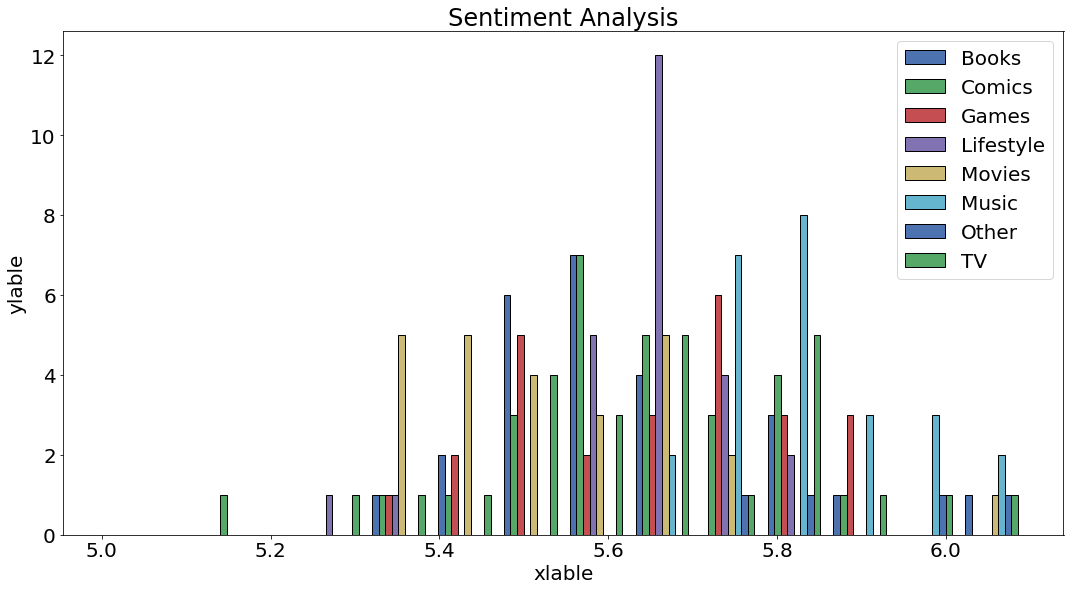

In [100]:
sentiment_hub_hist = {}
for k,v in sentiment_hub.items():
    sentiment_hub_hist[k] = [s[1] for s in v]

createHistigram("ylable", "xlable", "Sentiment Analysis", "Sentiment_Analysis", sentiment_hub_hist, 10, 5)

In [93]:
m_hub = {}
o_hub = {}

for k,v in sentiment_hub_hist.items():
    m_hub[k] = np.average(v)
    o_hub[k] = np.std(v)
    
    print("%s: average: %s, std: %s" % (k, m_hub[k], o_hub[k]))

Books: average: 5.611630469220481, std: 0.14727857111129095
Comics: average: 5.643075201804617, std: 0.1279996774498726
Games: average: 5.6649517382398225, std: 0.15488483400813652
Lifestyle: average: 5.652032344656147, std: 0.11760695859637367
Movies: average: 5.549798602095702, std: 0.16707500791119187
Music: average: 5.841438027389414, std: 0.10793320574781158
Other: average: 5.891935733498666, std: 0.15285997309111696
TV: average: 5.6432189026836745, std: 0.21102572440160497


In [101]:
def word_sentiment(word, average, ds):
    if word in ds['word'].values:
        return ds.loc[ds['word'] == word]['happiness_average'].values[0]
    return average

In [ ]:
# Positive words
positive_hub = {}

for k,v in hub_articles_wiki_filtered.items():
    limit = m_hub[k]+10*o_hub[k]
    for wikis in v.values():
        positive_hub[k] = " ".join([word for word in wikis if word_sentiment(word,m_hub[k],dsS1)>limit]) 
        
    print("%s: positive words: %s" % (k, positive_hub[k][:100]))
    print(len(positive_hub[k]))

Books: positive words: intelligence movies united books like movies excellent bright coffee intelligence knowledge intellig
2379


Wordclouds for positive words

In [ ]:
fig, axs = plt.subplots(ncols=2, nrows=4, figsize=(10, 20))
c=0
r=0
for k, words in positive_hub:
    if c<2:
        c+=1
    else:
        r+=1
        c=0
        
    wordcloud = WordCloud(background_color='white').generate(positive_hub[k])
    axs[r][c].imshow(wordcloud, interpolation="bilinear")
    axs[r][c].title('Word-cloud for positive words in '+k,)
    axs[r][c].axis("off")

plt.show() 


In [83]:
# Negative words
negativ_hub = {}

for k,v in hub_articles_wiki_filtered.items():
    for wikis in v.values():
        limit = m_hub[k]-10*o_hub[k]
        negativ_hub[k] = " ".join([word for word in wikis if word_sentiment(word,m_hub[k],dsS1)<limit]) 
        
    print("%s: negative words: %s" % (k, negativ_hub[k][:100]))

Books: negative words:  KevinDeer Wiki
Comics: negative words:  Ladynette Wiki El Legendario Escultor de la Luz Lunar Wiki Boruto Wikia
Games: negative words:  Remothered Wiki Lies Of Astaroth Wiki Legendary Wikia
Lifestyle: negative words:  Logopedia Wiki HealthyLifestyle Wiki Villains Fanon Wiki Caymanology Wiki Wumbology Wiki Vexillology Wiki
Movies: negative words:  电影维基_Wikia SuprmeScientistKevin Wiki MARIOplayerPLRANDOM Wiki Https://evaherbalist.com/genodrive/ Wiki Selebrityfeed Wiki Boruto Wiki
Music: negative words:  音乐 Doblaje Letras
Other: negative words:  Вики Сообщества 微軟 Wiki Orwell Wiki DogeTheChicken Wiki
TV: negative words:  中文電視大典 Iptv Wiki Adventures of the PAW Patrol 2 Wiki Motu Patlu Wiki


Wordclouds for negative words

In [ ]:
fig, axs = plt.subplots(ncols=2, nrows=4, figsize=(10, 20))
c=0
r=0
for k, words in positive_hub:
    if c<2:
        c+=1
    else:
        r+=1
        c=0
        
    wordcloud = WordCloud(background_color='white').generate(words)
    axs[r][c].imshow(wordcloud, interpolation="bilinear")
    axs[r][c].title('Word-cloud for positive words in', k)
    axs[r][c].axis("off")

plt.show() 



#### Discussion

## 4 Discussion

* What went well?,
* What is still missing? What could be improved?, Why?